In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [156]:
data = {
    'Likes Breaking Bad': [1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
    'Likes Stranger Things': [1, 1, 0, 1, 0, 1, 1, 0, 1, 0],
    'Likes The Good Place': [0, 1, 1, 0, 1, 0, 1, 1, 0, 1],
    'Likes Parks & Rec': [1, 0, 1, 0, 1, 1, 1, 0, 1, 0],
    'Age': [25, 30, 22, 35, 28, 40, 45, 50, 55, 60],
    'Likes Severance':   [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
}

df = pd.DataFrame(data)

X = df.drop(columns=['Likes Severance']).values
y = df['Likes Severance'].values

df

,Likes Breaking Bad,Likes Stranger Things,Likes The Good Place,Likes Parks & Rec,Age,Likes Severance
0,1,1,0,1,25,1
1,0,1,1,0,30,0
2,1,0,1,1,22,1
3,1,1,0,0,35,0
4,0,0,1,1,28,1
5,1,1,0,1,40,0
6,0,1,1,1,45,1
7,1,0,1,0,50,0
8,1,1,0,1,55,1
9,0,0,1,0,60,0


In [157]:
def gini_numeric(X, y):
    m = len(y)
    X_sorted = np.sort(X)
    best_impurity = 1
    best_cut = None
    for i in range(1, m):
        cut = (X_sorted[i] + X_sorted[i - 1]) / 2
        true_indexes = np.where(X < cut)[0]
        false_indexes = np.where(X >= cut)[0]
        true_Y = np.sum(y[true_indexes] == 1)
        true_N = np.sum(y[true_indexes] == 0)
        false_Y = np.sum(y[false_indexes] == 1)
        false_N = np.sum(y[false_indexes] == 0)
        true_total = true_Y + true_N
        false_total = false_Y + false_N
        true_impurity = 1 - (true_Y / true_total)**2 - (true_N / true_total)**2 if true_total > 0 else 0
        false_impurity = 1 - (false_Y / false_total)**2 - (false_N / false_total)**2 if false_total > 0 else 0
        total_impurity = (true_total / m) * true_impurity + (false_total / m) * false_impurity
        if total_impurity < best_impurity:
            best_impurity = total_impurity
            best_cut = cut
    return best_cut, best_impurity

gini_numeric(X[:, 4], y)

(np.float64(29.0), np.float64(0.2857142857142857))

In [158]:
def gini_impurity(X, y):
    m = len(y)
    if len(np.unique(X)) == 2:
        true_Y = np.sum((X == 1) & (y == 1))
        true_N = np.sum((X == 1) & (y == 0))
        false_Y = np.sum((X == 0) & (y == 1))
        false_N = np.sum((X == 0) & (y == 0))
        true_total = true_Y + true_N
        false_total = false_Y + false_N
        true_impurity = 1 - (true_Y / true_total)**2 - (true_N / true_total)**2 if true_total > 0 else 0
        false_impurity = 1 - (false_Y / false_total)**2 - (false_N / false_total)**2 if false_total > 0 else 0
        impurity = (true_total / m) * true_impurity + (false_total / m) * false_impurity
    else:
        impurity = gini_numeric(X, y)
    return impurity

gini_impurity(X[:, 4], y)

(np.float64(29.0), np.float64(0.2857142857142857))

In [159]:
def select_first_node(X, y):
    n, m = X.shape
    best_impurity = 1
    best_feature = None
    best_cut = None
    for i in range(m):
        feature = X[:, i]
        impurity_result = gini_impurity(feature, y)
        if isinstance(impurity_result, tuple):
            temp, impurity = impurity_result
        else:
            impurity = impurity_result
            temp = None
        if impurity < best_impurity:
            best_impurity = impurity
            best_feature = i
            best_cut = temp
    return best_feature, best_impurity, best_cut
        

select_first_node(X, y)


(3, np.float64(0.1666666666666666), None)

In [160]:
class ClassificationTree:
    def __init__(self, min_samples_split=2, max_depth=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
        
    class Node:
        def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
            self.feature = feature      # Index of feature to split on
            self.threshold = threshold  # Threshold value for numeric features
            self.left = left           # Left child node
            self.right = right         # Right child node
            self.value = value         # Predicted class if leaf node

    def fit(self, X, y):
        self.root = self._grow_tree(X, y, depth=0)
        return self

    def _grow_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Stopping criteria
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           n_classes == 1:
            leaf_value = self._most_common_class(y)
            return self.Node(value=leaf_value)

        # Find best split
        best_feature, best_impurity, best_cut = select_first_node(X, y)
        
        # If no valid split found
        if best_feature is None or best_impurity == 1:
            leaf_value = self._most_common_class(y)
            return self.Node(value=leaf_value)

        # Create child splits
        feature_values = X[:, best_feature]
        if best_cut is None:  # Binary feature
            left_idx = feature_values == 0
            right_idx = feature_values == 1
        else:  # Numeric feature
            left_idx = feature_values < best_cut
            right_idx = feature_values >= best_cut

        # Check if split would create empty nodes
        if np.sum(left_idx) == 0 or np.sum(right_idx) == 0:
            leaf_value = self._most_common_class(y)
            return self.Node(value=leaf_value)

        # Recursively build subtrees
        left = self._grow_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._grow_tree(X[right_idx], y[right_idx], depth + 1)
        
        return self.Node(best_feature, best_cut, left, right)

    def _most_common_class(self, y):
        return np.bincount(y).argmax()

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
            
        if node.threshold is None:  # Binary feature
            if x[node.feature] == 0:
                return self._traverse_tree(x, node.left)
            return self._traverse_tree(x, node.right)
        else:  # Numeric feature
            if x[node.feature] < node.threshold:
                return self._traverse_tree(x, node.left)
            return self._traverse_tree(x, node.right)

In [163]:
tree2 = ClassificationTree(max_depth=1)

tree2.fit(X,y)
ypreds = tree2.predict(X)

In [164]:
df_res = pd.DataFrame({'Actual': y, 'Pred.': ypreds})
print(f'Accuracy: {round(np.mean(y == ypreds), 2)}')

df_res

Accuracy: 0.9


,Actual,Pred.
0,1,1
1,0,0
2,1,1
3,0,0
4,1,1
5,0,1
6,1,1
7,0,0
8,1,1
9,0,0


In [165]:
X = np.random.rand(10000, 2) * 2 - 1

y = ((X[:, 0] > 0) & (X[:, 1] < 0)) | ((X[:, 0] < 0) & (X[:, 1] > 0)).astype(int)

df = pd.DataFrame(X, columns=['x1', 'x2'])
df['y'] = y

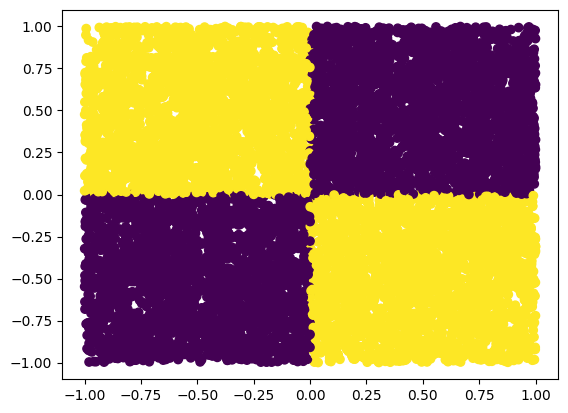

In [166]:
plt.scatter(X[:,0], X[:,1], c=y)

In [169]:
tree = ClassificationTree(max_depth=2)
tree.fit(X, y)
preds = tree.predict(X)

df_res = pd.DataFrame({'Actual': y,'Preds':preds})

print(f'Accuracy: {np.mean(preds == y)}')
df_res.head()

Accuracy: 0.5159


,Actual,Preds
0,0,1
1,1,0
2,0,1
3,1,1
4,0,1


In [170]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=2)

clf.fit(X,y)
preds = clf.predict(X)

df_res = pd.DataFrame({'Actual': y,'Preds':preds})

print(f'Accuracy: {np.mean(preds == y)}')
df_res.head()

Accuracy: 0.5159


,Actual,Preds
0,0,1
1,1,0
2,0,1
3,1,1
4,0,1
